In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from data_collection import Collection1, Collection2
import xgboost as xgb

## Data Collection

In [20]:
[X_train,Y_train,X_test,ID_test] = Collection1.parse_telecom_data(filename_train='train.csv',filename_test='test.csv')

[X_train,Y_train,X_test,ID_test] = Collection2.parse_telecom_data(filename_train='train.csv',filename_test='test.csv')

## XGBoost case study

0.1
0.2
0.30000000000000004
0.4
0.5


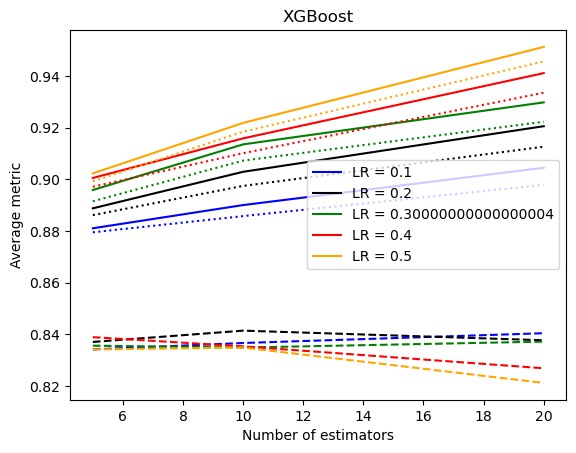

In [32]:
# AdaBoost case study
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True)    

n_est_list = [5, 10, 20]
learn_rate_list = np.linspace(0.1,0.5, 5)
c = ['b', 'k', 'g', 'r', 'orange']

fig, ax = plt.subplots()

for i,lr in enumerate(learn_rate_list):
    print(lr)
    avg_train_metric = np.zeros((len(n_est_list),))
    avg_val_metric = np.zeros((len(n_est_list),))
    avg_full_metric = np.zeros((len(n_est_list),))
    for j,n_est in enumerate(n_est_list):
        train_Metric = 0
        val_Metric = 0
        y_train_prob_avg = 0

        for train_idx, val_idx in kf.split(X_train[:,0]):
            x_train, x_val = X_train[train_idx,:], X_train[val_idx,:]
            y_train, y_val = Y_train[train_idx], Y_train[val_idx]

            clf = xgb.XGBClassifier(n_estimators=n_est, learning_rate=lr, booster="dart", gamma = 0.1)
            clf.fit(x_train, y_train.flatten())
            
            y_train_prob = clf.predict_proba(x_train)
            thisMetric = metrics.roc_auc_score(y_train, y_train_prob[:,1])
            train_Metric += thisMetric

            y_train_prob = clf.predict_proba(x_val)
            thisMetric = metrics.roc_auc_score(y_val, y_train_prob[:,1])
            val_Metric += thisMetric

            y_train_prob = clf.predict_proba(X_train)
            y_train_prob_avg += y_train_prob[:,1]

        avg_train_metric[j] = train_Metric/n_folds
        avg_val_metric[j] = val_Metric/n_folds
        avg_full_metric[j] = metrics.roc_auc_score(Y_train, y_train_prob_avg/n_folds)

    ax.plot(n_est_list,avg_train_metric, color=c[i], label=f'LR = {lr}')
    ax.plot(n_est_list,avg_val_metric, color=c[i], linestyle='--')
    ax.plot(n_est_list,avg_full_metric, color=c[i], linestyle=':')
    ax.set_xlabel('Number of estimators')
    ax.set_ylabel('Average metric')
    plt.title('XGBoost')

plt.legend()
plt.show()

## XGBoost Collection

In [35]:
n_folds = 5
kf = KFold(n_splits=n_folds)    
i = 0
train_Metric = 0
val_Metric = 0
y_train_prob_avg = 0
y_test_prob_avg = 0

for train_idx, val_idx in kf.split(X_train[:,0]):
    print(f'--------------- k-fold {i} ---------------')
    x_train, x_val = X_train[train_idx,:], X_train[val_idx,:]
    y_train, y_val = Y_train[train_idx], Y_train[val_idx]

    clf = xgb.XGBClassifier(n_estimators=5, learning_rate=0.4);
    clf.fit(x_train, y_train.flatten());
    
    y_prob = clf.predict_proba(x_train);
    thisMetric = metrics.roc_auc_score(y_train, y_prob[:,1]);
    train_Metric += thisMetric
    print("Training metric: ",thisMetric)

    y_prob = clf.predict_proba(x_val);
    thisMetric = metrics.roc_auc_score(y_val, y_prob[:,1]);
    val_Metric += thisMetric
    print("Testing metric: ",thisMetric)

    y_train_prob = clf.predict_proba(X_train);
    y_train_prob_avg += y_train_prob[:,1]

    y_test_prob = clf.predict_proba(X_test);
    y_test_prob_avg += y_test_prob[:,1]
    print(' ')

    i += 1

print(f'Average training metric: {train_Metric/n_folds}')
print(f'Average testing metric: {val_Metric/n_folds}')
thisMetric = metrics.roc_auc_score(Y_train, y_train_prob_avg/n_folds);
print(f'Full training metric: {thisMetric}')

y_test_prob = y_test_prob_avg/n_folds
thisData = np.concatenate((ID_test, np.reshape(y_test_prob,(-1,1))), axis=1);
thisLabel = ['ID','TARGET'];
y_test_prob_pd = pd.DataFrame(data=thisData,columns=thisLabel)
fname_submit = 'test_submission_Wei.csv';
y_test_prob_pd.to_csv(fname_submit,index=False);

--------------- k-fold 0 ---------------
Training metric:  0.9028538700190093
Testing metric:  0.8306181357364123
 
--------------- k-fold 1 ---------------
Training metric:  0.9004314240524205
Testing metric:  0.855705276530103
 
--------------- k-fold 2 ---------------
Training metric:  0.9027387051303344
Testing metric:  0.8288407846066297
 
--------------- k-fold 3 ---------------
Training metric:  0.9029033595313577
Testing metric:  0.821235448404714
 
--------------- k-fold 4 ---------------
Training metric:  0.8965945849657517
Testing metric:  0.8487242746947316
 
Average training metric: 0.9011043887397747
Average testing metric: 0.8370247839945181
Full training metric: 0.8977610522773896
